Data Preprocessing
This section handles data cleaning, transformation, and feature engineering to prepare the dataset for analysis.

Objectives
Clean invalid transactions (e.g., negative quantities, zero prices, canceled orders)
Handle missing values (specifically for CustomerID)
Create temporal features (year, month, day of week, hour) from the InvoiceDate
Calculate derived metrics like basket size and transaction value

In [2]:
# Load dataset
import pandas as pd
import os

# Set the project root directory (adjust if needed)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
data_path = os.path.join(project_root, 'data', 'raw', 'Online Retail.csv')

# Alternative: Use absolute path directly
# data_path = '/Users/monurajj/Desktop/Projects/Retail-Stock-Market-Behavior-Analysis/data/raw/Online Retail.csv'

df = pd.read_csv(data_path, encoding='latin-1')

print("Initial dataset shape:", df.shape)
df.head()


Initial dataset shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/01/2010 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/01/2010 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/01/2010 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/01/2010 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/01/2010 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Remove rows with missing CustomerID
df.dropna(subset=['CustomerID'], inplace=True)

# Convert CustomerID to integer type
df['CustomerID'] = df['CustomerID'].astype(int)

# Remove canceled orders (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Remove rows with negative Quantity
df = df[df['Quantity'] > 0]

# Remove rows with UnitPrice equal to 0
df = df[df['UnitPrice'] > 0]

# Remove rows with missing Description
df = df[df['Description'].notna()]

# Remove duplicate rows if any
initial_shape = df.shape[0]
df = df.drop_duplicates()
duplicates_removed = initial_shape - df.shape[0]
if duplicates_removed > 0:
    print(f"Removed {duplicates_removed} duplicate rows")

# Display shape after cleaning
print("Shape after cleaning:", df.shape)
print(f"Removed {541909 - df.shape[0]} rows total ({((541909 - df.shape[0])/541909*100):.2f}%)")

df.head()

Removed 5192 duplicate rows
Shape after cleaning: (392692, 8)
Removed 149217 rows total (27.54%)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/01/2010 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/01/2010 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/01/2010 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/01/2010 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/01/2010 08:26:00,3.39,17850,United Kingdom


In [4]:

# Calculate 'Total Price' for each transaction
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Calculate 'Basket Size' (number of unique products in each invoice)
basket_size = df.groupby('InvoiceNo')['StockCode'].nunique().reset_index()
basket_size.columns = ['InvoiceNo', 'BasketSize']
df = pd.merge(df, basket_size, on='InvoiceNo', how='left')

# Calculate 'Transaction Value' (sum of TotalPrice for each invoice)
transaction_value = df.groupby('InvoiceNo')['TotalPrice'].sum().reset_index()
transaction_value.columns = ['InvoiceNo', 'TransactionValue']
df = pd.merge(df, transaction_value, on='InvoiceNo', how='left')

# Display the updated DataFrame with new metrics and temporal features
display(df.head())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,BasketSize,TransactionValue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/01/2010 08:26:00,2.55,17850,United Kingdom,15.30,7,139.12
1,536365,71053,WHITE METAL LANTERN,6,12/01/2010 08:26:00,3.39,17850,United Kingdom,20.34,7,139.12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/01/2010 08:26:00,2.75,17850,United Kingdom,22.00,7,139.12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/01/2010 08:26:00,3.39,17850,United Kingdom,20.34,7,139.12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/01/2010 08:26:00,3.39,17850,United Kingdom,20.34,7,139.12


In [5]:
# Create temporal features from InvoiceDate
# Convert InvoiceDate to datetime - try multiple formats
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], infer_datetime_format=True, errors='coerce')

# Check for any remaining NaT values
nat_count = df['InvoiceDate'].isna().sum()
if nat_count > 0:
    print(f"Warning: {nat_count} rows have invalid dates and will be removed")
    df = df[df['InvoiceDate'].notna()]

# Extract temporal features
df['InvoiceYear'] = df['InvoiceDate'].dt.year
df['InvoiceMonth'] = df['InvoiceDate'].dt.month
df['InvoiceDay'] = df['InvoiceDate'].dt.day
df['InvoiceDayOfWeek'] = df['InvoiceDate'].dt.dayofweek  # 0=Monday, 6=Sunday
df['InvoiceDayName'] = df['InvoiceDate'].dt.day_name()
df['InvoiceHour'] = df['InvoiceDate'].dt.hour
df['InvoiceQuarter'] = df['InvoiceDate'].dt.quarter
df['InvoiceWeek'] = df['InvoiceDate'].dt.isocalendar().week

# Create MonthYear as string for easier plotting (YYYY-MM format)
df['InvoiceMonthYear'] = df['InvoiceDate'].dt.to_period('M').astype(str)

# Create time of day categories
df['TimeOfDay'] = pd.cut(df['InvoiceHour'], 
                         bins=[0, 6, 12, 18, 24], 
                         labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                         include_lowest=True)

# Create season based on month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['Season'] = df['InvoiceMonth'].apply(get_season)

# Display info about temporal features
print("Temporal features created:")
print(f"Date range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")
print(f"\nData shape after temporal feature creation: {df.shape}")
print(f"\nSample temporal features:")
df[['InvoiceDate', 'InvoiceYear', 'InvoiceMonth', 'InvoiceDayOfWeek', 'InvoiceHour', 'InvoiceMonthYear', 'Season', 'TimeOfDay']].head()


/var/folders/jq/sgk4cth562l_wxqd3cdncwdh0000gn/T/ipykernel_39511/1915854358.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], infer_datetime_format=True, errors='coerce')


Temporal features created:
Date range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00

Data shape after temporal feature creation: (392692, 22)

Sample temporal features:


,InvoiceDate,InvoiceYear,InvoiceMonth,InvoiceDayOfWeek,InvoiceHour,InvoiceMonthYear,Season,TimeOfDay
0,2010-12-01 08:26:00,2010,12,2,8,2010-12,Winter,Morning
1,2010-12-01 08:26:00,2010,12,2,8,2010-12,Winter,Morning
2,2010-12-01 08:26:00,2010,12,2,8,2010-12,Winter,Morning
3,2010-12-01 08:26:00,2010,12,2,8,2010-12,Winter,Morning
4,2010-12-01 08:26:00,2010,12,2,8,2010-12,Winter,Morning


## Additional Feature Engineering

Create customer-level and product-level features for deeper analysis.


In [6]:
# Customer-level features
import numpy as np

customer_stats = df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',  # Number of unique invoices
    'TotalPrice': ['sum', 'mean'],  # Total and average spending
    'Quantity': 'sum',  # Total items purchased
    'InvoiceDate': ['min', 'max']  # First and last purchase dates
}).reset_index()

# Flatten column names
customer_stats.columns = ['CustomerID', 'NumTransactions', 'TotalSpent', 'AvgTransactionValue', 
                          'TotalItems', 'FirstPurchase', 'LastPurchase']

# Calculate customer lifetime (days between first and last purchase)
customer_stats['CustomerLifetimeDays'] = (customer_stats['LastPurchase'] - customer_stats['FirstPurchase']).dt.days
customer_stats['CustomerLifetimeDays'] = customer_stats['CustomerLifetimeDays'].fillna(0)

# Calculate average days between transactions
customer_stats['AvgDaysBetweenTransactions'] = customer_stats['CustomerLifetimeDays'] / customer_stats['NumTransactions'].replace(0, 1)
customer_stats['AvgDaysBetweenTransactions'] = customer_stats['AvgDaysBetweenTransactions'].replace([np.inf, -np.inf], 0)

# Merge customer features back to main dataframe
df = df.merge(customer_stats[['CustomerID', 'NumTransactions', 'TotalSpent', 'AvgTransactionValue', 
                               'CustomerLifetimeDays', 'AvgDaysBetweenTransactions']], 
              on='CustomerID', how='left')

print("Customer-level features created:")
print(f"Total unique customers: {df['CustomerID'].nunique()}")
print(f"\nCustomer statistics summary:")
print(customer_stats[['NumTransactions', 'TotalSpent', 'AvgTransactionValue', 'CustomerLifetimeDays']].describe())


Customer-level features created:
Total unique customers: 4338

Customer statistics summary:
       NumTransactions     TotalSpent  AvgTransactionValue  \
count      4338.000000    4338.000000          4338.000000   
mean          4.272015    2048.688081            68.381590   
std           7.697998    8985.230220          1467.918294   
min           1.000000       3.750000             2.136970   
25%           1.000000     306.482500            12.393196   
50%           2.000000     668.570000            17.755000   
75%           5.000000    1660.597500            24.878950   
max         209.000000  280206.020000         77183.600000   

       CustomerLifetimeDays  
count           4338.000000  
mean             130.448594  
std              132.039554  
min                0.000000  
25%                0.000000  
50%               92.500000  
75%              251.750000  
max              373.000000  


Sales Trends Over Time

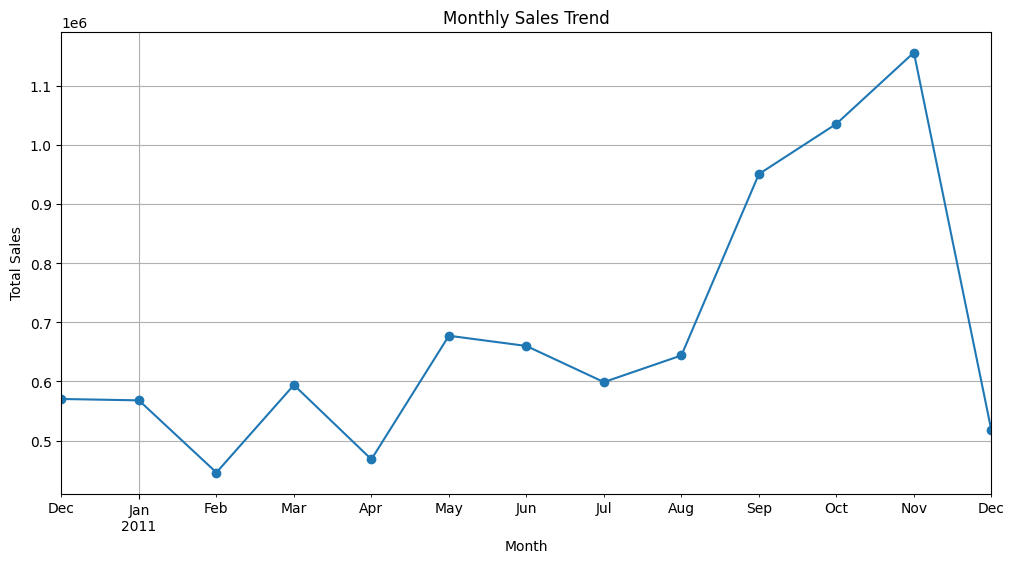

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert 'InvoiceDate' to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create 'InvoiceMonth' column
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

# Monthly sales trend
monthly_sales = df.groupby('InvoiceMonth')['TotalPrice'].sum()
plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='line', marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

Top Selling Products

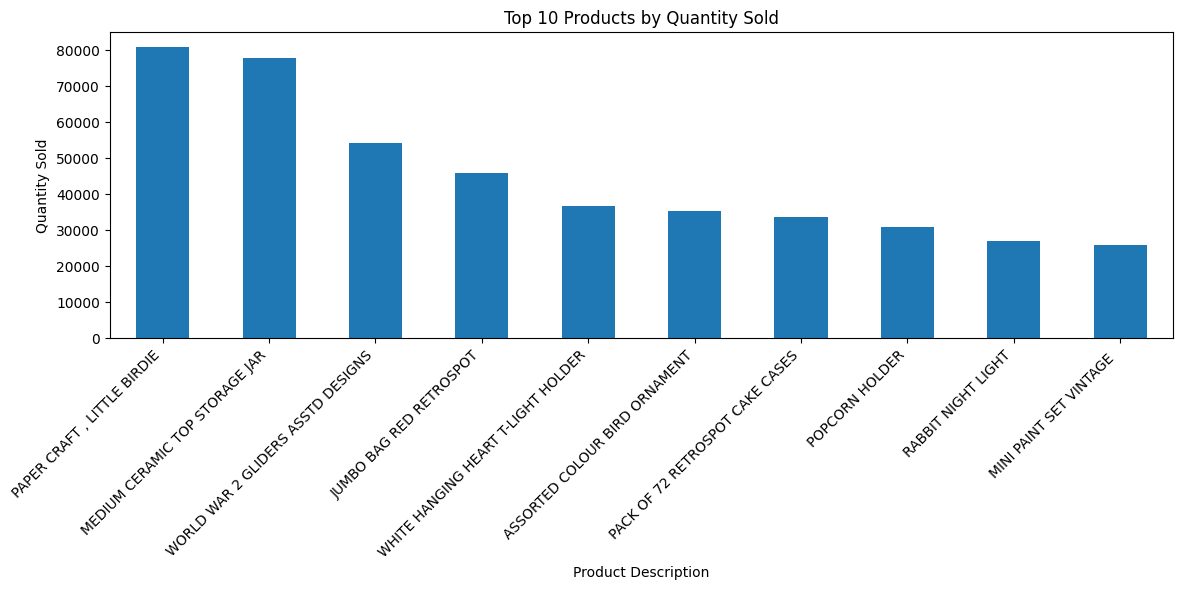

In [8]:
# Top 10 products by quantity sold
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
top_products.plot(kind='bar')
plt.title('Top 10 Products by Quantity Sold')
plt.xlabel('Product Description')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Customer Geographic Distribution

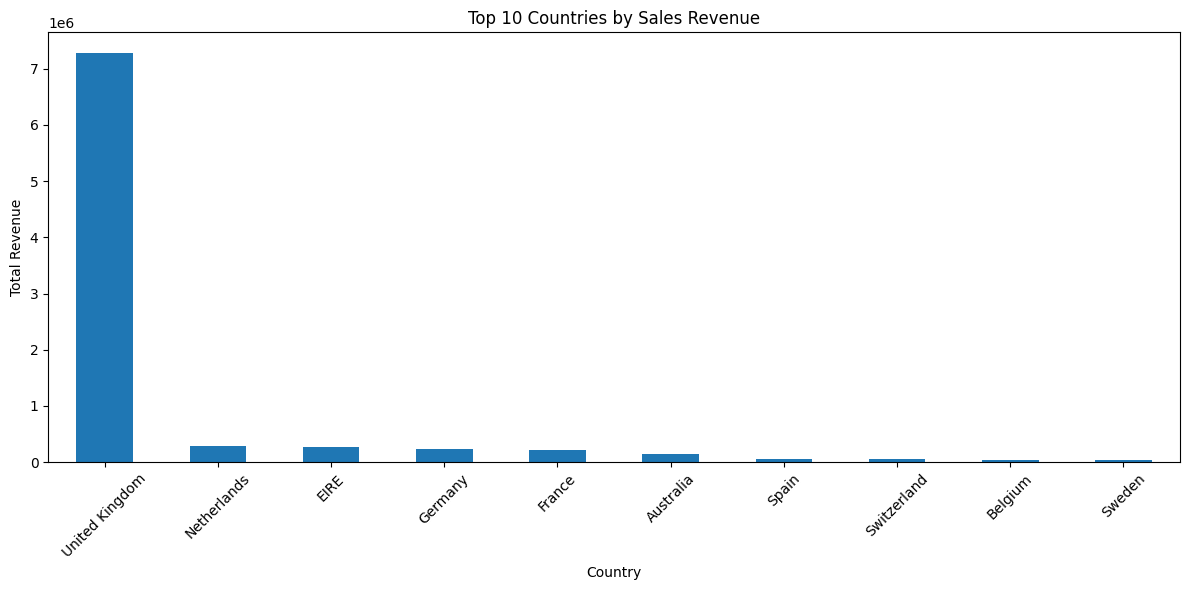

In [9]:
# Sales by country
country_sales = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
country_sales.plot(kind='bar')
plt.title('Top 10 Countries by Sales Revenue')
plt.xlabel('Country')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Seasonal Patterns

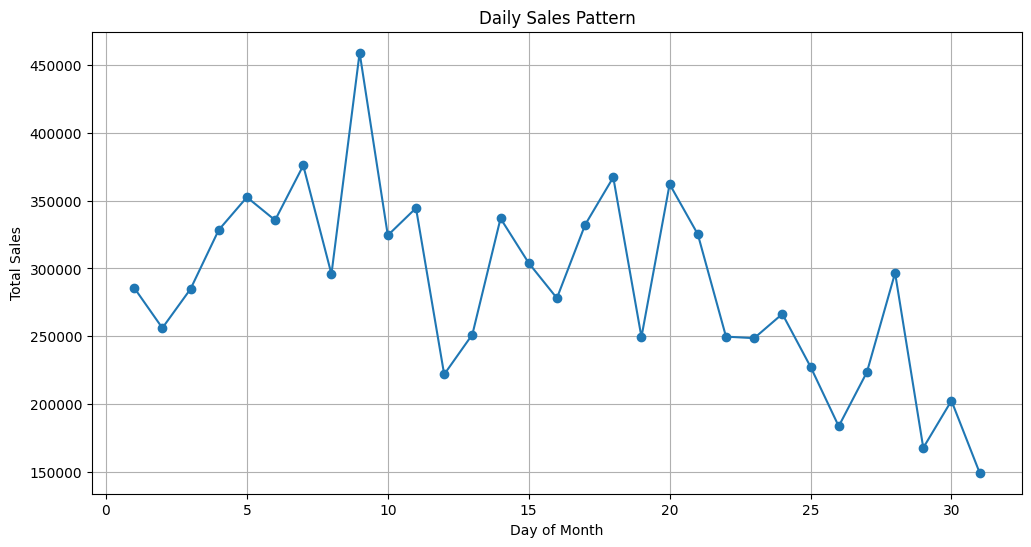

In [10]:
# Daily sales pattern
daily_sales = df.groupby('InvoiceDay')['TotalPrice'].sum()

plt.figure(figsize=(12, 6))
daily_sales.plot(kind='line', marker='o')
plt.title('Daily Sales Pattern')
plt.xlabel('Day of Month')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

Top Customers

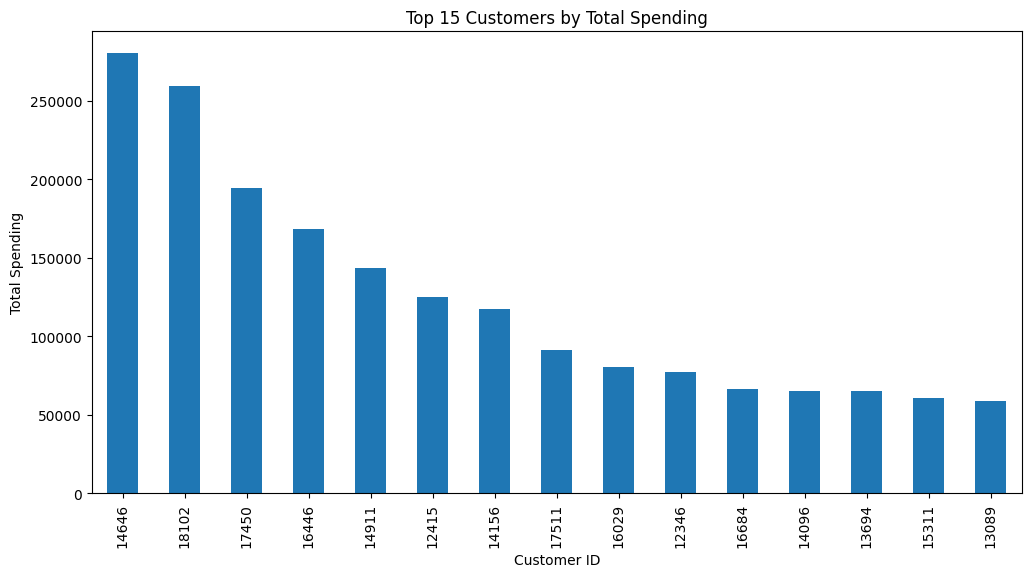

In [11]:
# Top 15 customers by spending
top_customers = df.groupby('CustomerID')['TotalPrice'].sum().sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 6))
top_customers.plot(kind='bar')
plt.title('Top 15 Customers by Total Spending')
plt.xlabel('Customer ID')
plt.ylabel('Total Spending')
plt.show()

Outlier Detection Methods

In [12]:
import numpy as np
import seaborn as sns
from scipy import stats

# First, let's identify numerical columns that might have outliers
numerical_cols = ['Quantity', 'UnitPrice', 'TotalPrice', 'BasketSize', 'TransactionValue']

print("Dataset shape before outlier handling:", df.shape)
print("\n--- Basic Statistics ---")
print(df[numerical_cols].describe())

Dataset shape before outlier handling: (392692, 27)

--- Basic Statistics ---
            Quantity      UnitPrice     TotalPrice     BasketSize  \
count  392692.000000  392692.000000  392692.000000  392692.000000   
mean       13.119702       3.125914      22.631500      48.268618   
std       180.492832      22.241836     311.099224      57.318082   
min         1.000000       0.001000       0.001000       1.000000   
25%         2.000000       1.250000       4.950000      19.000000   
50%         6.000000       1.950000      12.450000      33.000000   
75%        12.000000       3.750000      19.800000      57.000000   
max     80995.000000    8142.750000  168469.600000     541.000000   

       TransactionValue  
count     392692.000000  
mean         746.435962  
std         1483.586125  
min            0.380000  
25%          248.700000  
50%          392.490000  
75%          688.970000  
max       168469.600000  


Visual Outlier Detection

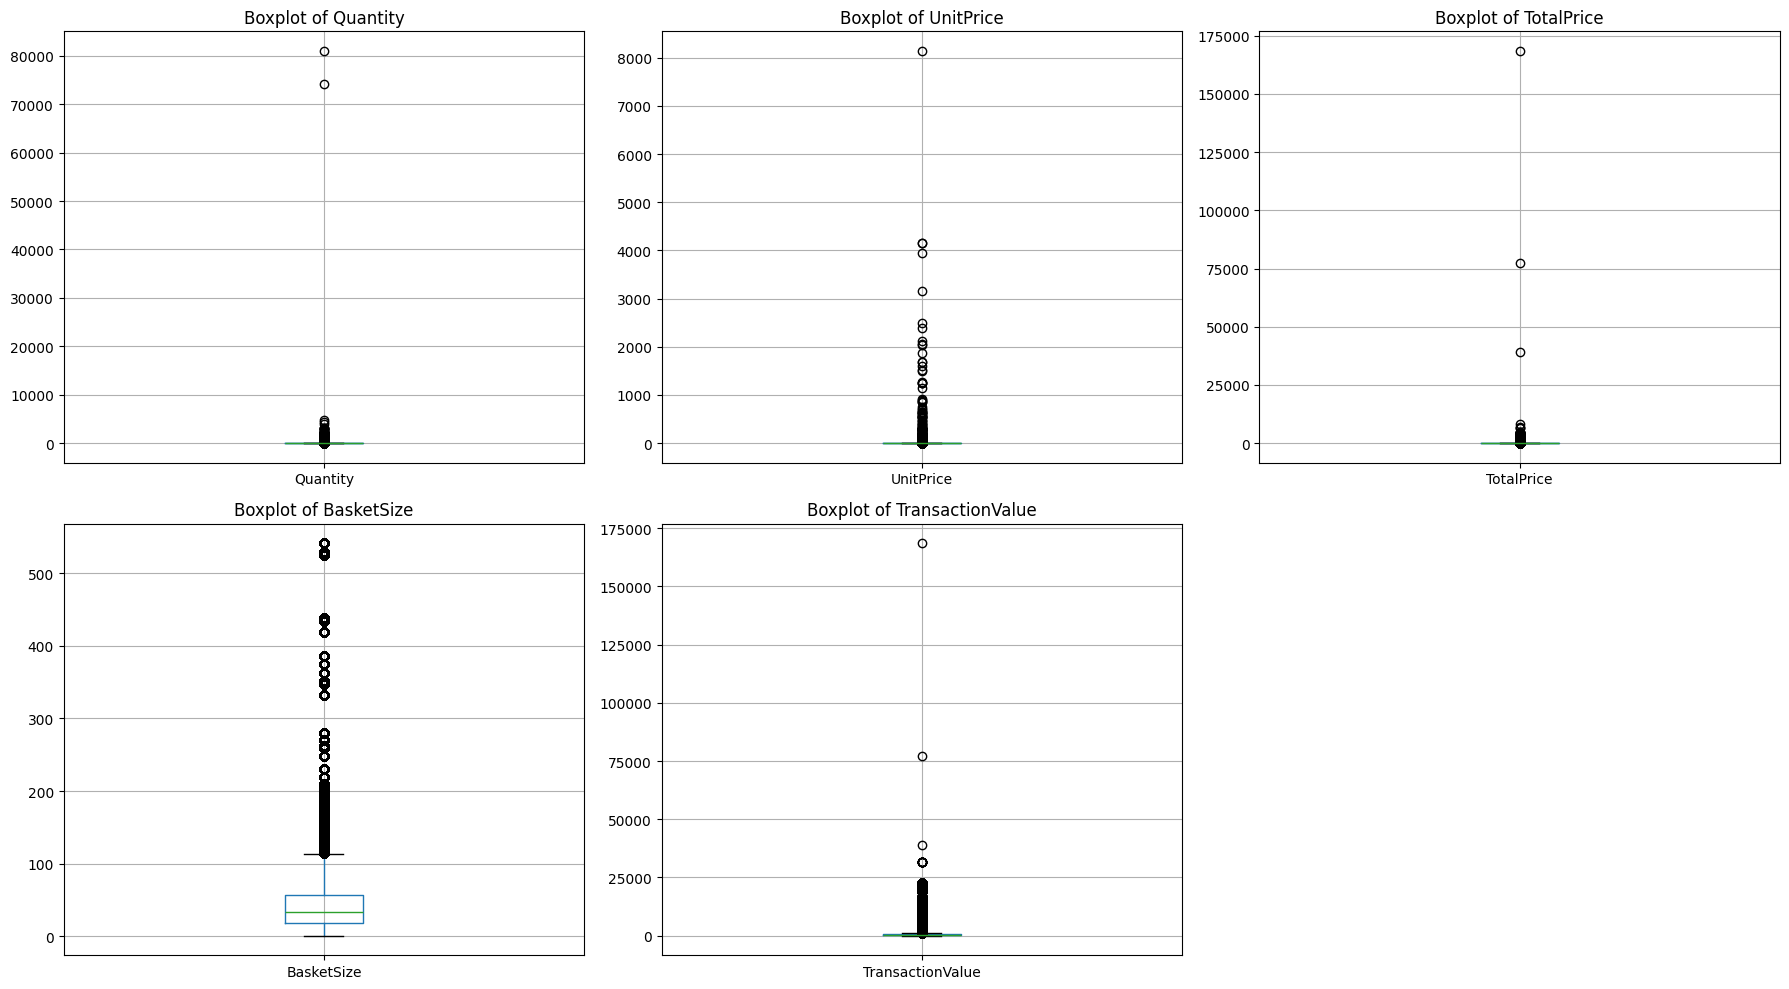

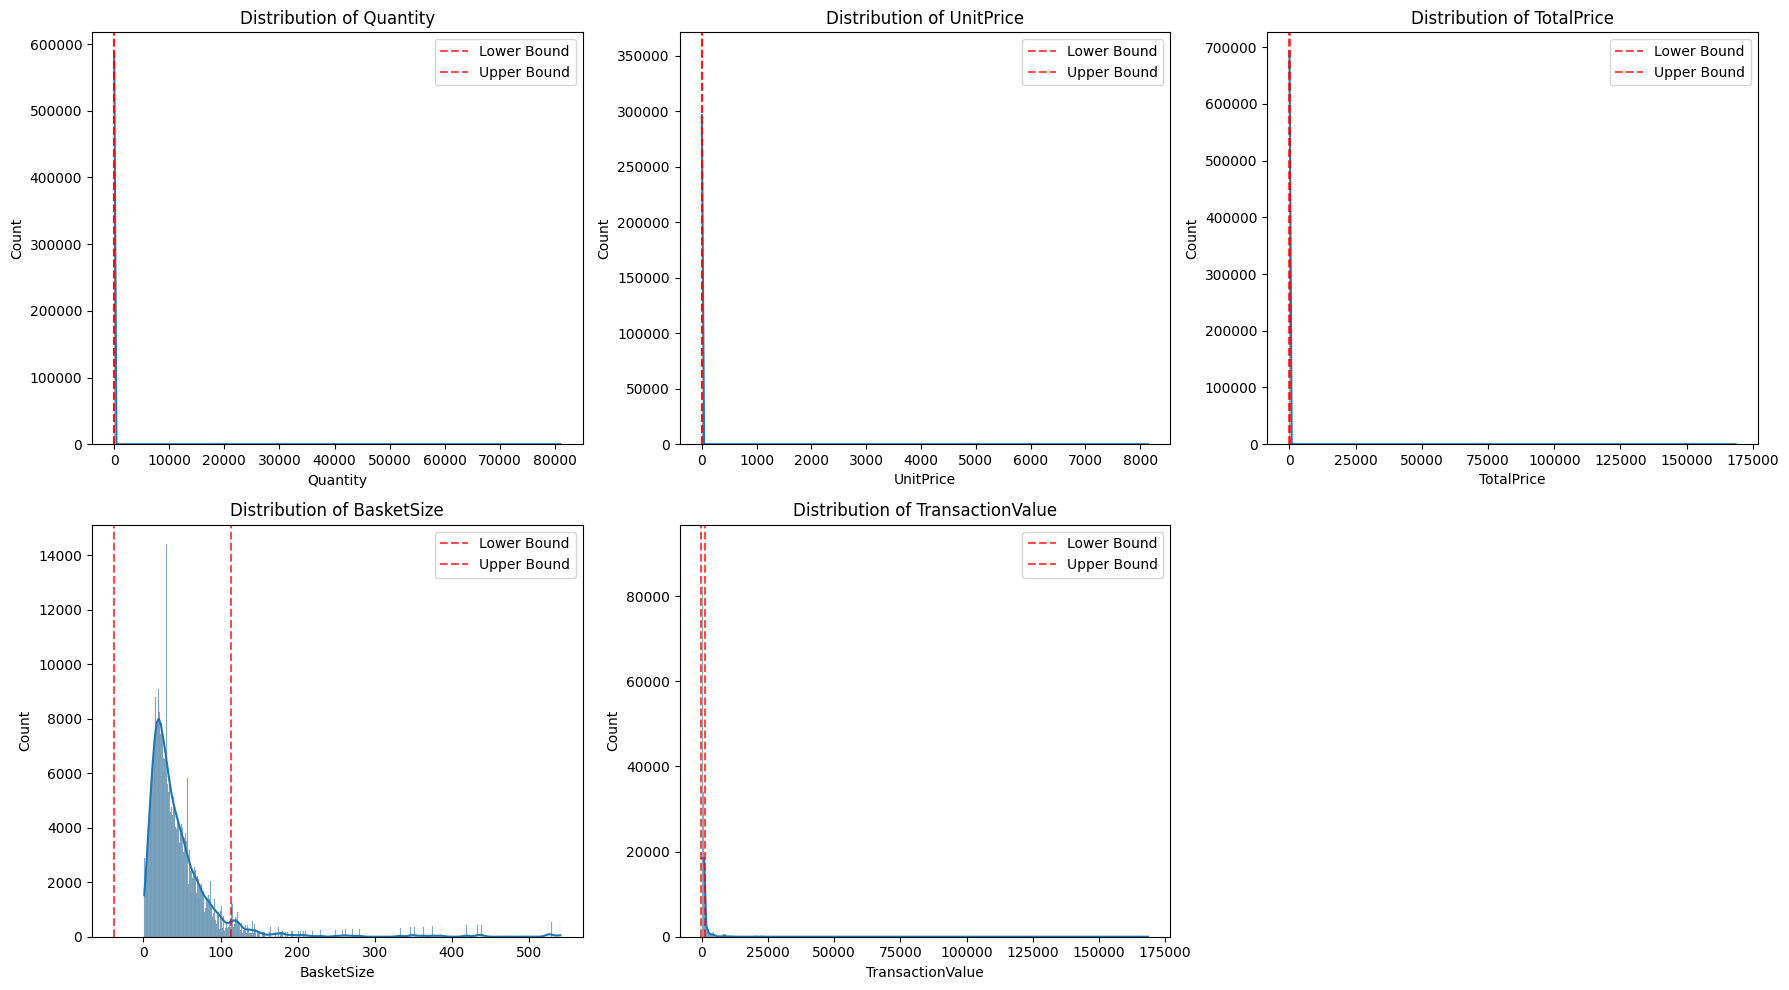

In [13]:
# Box plots for outlier visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    df.boxplot(column=col, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

# Remove empty subplot
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

# Distribution plots with outliers highlighted
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}')
    
    # Calculate outliers using IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    axes[i].axvline(lower_bound, color='red', linestyle='--', alpha=0.7, label='Lower Bound')
    axes[i].axvline(upper_bound, color='red', linestyle='--', alpha=0.7, label='Upper Bound')
    axes[i].legend()

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

Association rules are used for discovering interesting relationships between variables in large datasets, commonly known as market basket analysis, which helps with tasks like product recommendations, targeted marketing, and fraud detection. By identifying "if-then" patterns (e.g., "if customers buy milk and bread, they will also buy butter"), businesses can make better decisions about product placement, bundling, and marketing campaigns. 

In [15]:

# Perform initial cleaning steps on df (from previous successful cells)
df.dropna(subset=['CustomerID'], inplace=True)
df['CustomerID'] = df['CustomerID'].astype(int)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

# Original code for association data preparation
df_association = df[['InvoiceNo', 'Description']].copy()
df_association.dropna(subset=['Description'], inplace=True)
df_association['Description'] = df_association['Description'].str.strip()
df_association = df_association[df_association['Description'] != '']

# Group items by invoice
basket = df_association.groupby('InvoiceNo')['Description'].apply(list).reset_index()
basket.columns = ['InvoiceNo', 'Items']

display(basket.head())

,InvoiceNo,Items
0,536365,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET..."
1,536366,"[HAND WARMER UNION JACK, HAND WARMER RED POLKA..."
2,536367,"[ASSORTED COLOUR BIRD ORNAMENT, POPPY'S PLAYHO..."
3,536368,"[JAM MAKING SET WITH JARS, RED COAT RACK PARIS..."
4,536369,[BATH BUILDING BLOCK WORD]


In [16]:

# Perform initial cleaning steps on df (from previous successful cells)
df.dropna(subset=['CustomerID'], inplace=True)
df['CustomerID'] = df['CustomerID'].astype(int)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

# Calculate 'Total Price' for each transaction (from previous successful cell)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Convert 'InvoiceDate' to datetime and create temporal features (from previous successful cells)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
df['InvoiceDay'] = df['InvoiceDate'].dt.day

# Calculate 'Basket Size' (number of unique products in each invoice) (from previous successful cell)
basket_size = df.groupby('InvoiceNo')['StockCode'].nunique().reset_index()
basket_size.columns = ['InvoiceNo', 'BasketSize']
df = pd.merge(df, basket_size, on='InvoiceNo', how='left')

# Calculate 'Transaction Value' (sum of TotalPrice for each invoice) (from previous successful cell)
transaction_value = df.groupby('InvoiceNo')['TotalPrice'].sum().reset_index()
transaction_value.columns = ['InvoiceNo', 'TransactionValue']
df = pd.merge(df, transaction_value, on='InvoiceNo', how='left')

# Original code for association data preparation
df_association = df[['InvoiceNo', 'Description']].copy()
df_association.dropna(subset=['Description'], inplace=True)
df_association['Description'] = df_association['Description'].str.strip()
df_association = df_association[df_association['Description'] != '']

# Group items by invoice
basket = df_association.groupby('InvoiceNo')['Description'].apply(list).reset_index()
basket.columns = ['InvoiceNo', 'Items']

display(basket.head())

,InvoiceNo,Items
0,536365,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET..."
1,536366,"[HAND WARMER UNION JACK, HAND WARMER RED POLKA..."
2,536367,"[ASSORTED COLOUR BIRD ORNAMENT, POPPY'S PLAYHO..."
3,536368,"[JAM MAKING SET WITH JARS, RED COAT RACK PARIS..."
4,536369,[BATH BUILDING BLOCK WORD]


In [18]:
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd

# Extract the list of items from the 'basket' DataFrame
list_of_transactions = basket['Items'].tolist()

# Initialize the TransactionEncoder
te = TransactionEncoder()

# Fit and transform the data
te_ary = te.fit(list_of_transactions).transform(list_of_transactions)

# Convert the one-hot encoded array to a DataFrame
df_onehot = pd.DataFrame(te_ary, columns=te.columns_)

# Convert boolean values to integers (True to 1, False to 0)
df_onehot = df_onehot.astype(int)

# Set InvoiceNo as the index (if needed for later analysis, or just keep as is)
# For association rule mining, typically the DataFrame is just the items matrix.
# The 'basket' DataFrame has InvoiceNo, but df_onehot doesn't directly carry it unless we merge or set index.
# We will use the default index for now as mlxtend.frequent_patterns functions don't typically need InvoiceNo as a column.

display(df_onehot.head())

,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
import pandas as pd
import sys
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

# Install openpyxl if not already installed, as it's needed for .xlsx files
try:
    import openpyxl
except ImportError:
    print("Installing openpyxl...")
    !{sys.executable} -m pip install openpyxl
    import openpyxl

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"

# Load the dataset from the online .xlsx file
df = pd.read_excel(url)

# Perform initial cleaning steps on df
df.dropna(subset=['CustomerID'], inplace=True)
df['CustomerID'] = df['CustomerID'].astype(int)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

# Calculate 'Total Price' for each transaction
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Convert 'InvoiceDate' to datetime and create temporal features
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
df['InvoiceDay'] = df['InvoiceDate'].dt.day

# Calculate 'Basket Size' (number of unique products in each invoice)
basket_size = df.groupby('InvoiceNo')['StockCode'].nunique().reset_index()
basket_size.columns = ['InvoiceNo', 'BasketSize']
df = pd.merge(df, basket_size, on='InvoiceNo', how='left')

# Calculate 'Transaction Value' (sum of TotalPrice for each invoice)
transaction_value = df.groupby('InvoiceNo')['TotalPrice'].sum().reset_index()
transaction_value.columns = ['InvoiceNo', 'TransactionValue']
df = pd.merge(df, transaction_value, on='InvoiceNo', how='left')

# Original code for association data preparation
df_association = df[['InvoiceNo', 'Description']].copy()
df_association.dropna(subset=['Description'], inplace=True)
df_association['Description'] = df_association['Description'].str.strip()
df_association = df_association[df_association['Description'] != '']

# Group items by invoice to create 'basket'
basket = df_association.groupby('InvoiceNo')['Description'].apply(list).reset_index()
basket.columns = ['InvoiceNo', 'Items']

# Extract the list of items from the 'basket' DataFrame
list_of_transactions = basket['Items'].tolist()

# Initialize the TransactionEncoder
te = TransactionEncoder()

# Fit and transform the data
te_ary = te.fit(list_of_transactions).transform(list_of_transactions)

# Convert the one-hot encoded array to a DataFrame
df_onehot = pd.DataFrame(te_ary, columns=te.columns_)

# Convert boolean values to integers (True to 1, False to 0)
df_onehot = df_onehot.astype(int)

# Convert to sparse DataFrame (original creation of df_onehot_sparse)
df_onehot_sparse = df_onehot.astype(pd.SparseDtype("int", 0))

# Now, apply the fix for the DeprecationWarning:
# Convert the sparse DataFrame to boolean type as recommended by mlxtend
df_onehot_sparse_bool = df_onehot_sparse.astype(pd.SparseDtype("bool", False))

# Apply the Apriori algorithm to find frequent itemsets
# Setting a min_support value (e.g., 0.01) to filter out infrequent itemsets.
# This value can be adjusted based on the dataset size and desired granularity.
frequent_itemsets = apriori(df_onehot_sparse_bool, min_support=0.01, use_colnames=True)

# Sort the frequent itemsets by support in descending order
frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)

# Display the first few rows of the frequent itemsets
display(frequent_itemsets.head())

Installing openpyxl...


/opt/homebrew/Cellar/python@3.14/3.14.0_1/Frameworks/Python.framework/Versions/3.14/lib/python3.14/pty.py:66: DeprecationWarning: This process (pid=39511) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]1/2 [openpyxl]


,support,itemsets
587,0.106357,(WHITE HANGING HEART T-LIGHT HOLDER)
413,0.091895,(REGENCY CAKESTAND 3 TIER)
246,0.086337,(JUMBO BAG RED RETROSPOT)
337,0.074412,(PARTY BUNTING)
37,0.074196,(ASSORTED COLOUR BIRD ORNAMENT)
